In [ ]:
conda install -c conda-forge tensorflow-probability

In [ ]:
conda update -n base -c defaults conda

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

## Load dataset

In [3]:
df = pd.read_csv('Penguindata.csv')
df = df.dropna()
df.head()

,studyName,Sample Number,Species,Region,Latitude,Longitude,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
6,PAL0708,7,Adelie Penguin (Pygoscelis adeliae),Anvers,-64.766998,-64.083000,Torgersen,"Adult, 1 Egg Stage",N4A1,No,11/15/07,38.9,17.8,181.0,3625.0,FEMALE,9.18718,-25.21799,Nest never observed with full clutch.
7,PAL0708,8,Adelie Penguin (Pygoscelis adeliae),Anvers,-64.766998,-64.083000,Torgersen,"Adult, 1 Egg Stage",N4A2,No,11/15/07,39.2,19.6,195.0,4675.0,MALE,9.46060,-24.89958,Nest never observed with full clutch.
28,PAL0708,29,Adelie Penguin (Pygoscelis adeliae),Anvers,-64.800003,-63.833328,Biscoe,"Adult, 1 Egg Stage",N18A1,No,11/10/07,37.9,18.6,172.0,3150.0,FEMALE,8.38404,-25.19837,Nest never observed with full clutch.
29,PAL0708,30,Adelie Penguin (Pygoscelis adeliae),Anvers,-64.800003,-63.833328,Biscoe,"Adult, 1 Egg Stage",N18A2,No,11/10/07,40.5,18.9,180.0,3950.0,MALE,8.90027,-25.11609,Nest never observed with full clutch.
38,PAL0708,39,Adelie Penguin (Pygoscelis adeliae),Anvers,-64.733002,-64.233002,Dream,"Adult, 1 Egg Stage",N25A1,No,11/13/07,37.6,19.3,181.0,3300.0,FEMALE,9.41131,-25.04169,Nest never observed with full clutch.


## Split dataset

In [4]:
categories = df['Species'].unique()
cat_to_idx = {k:v for k,v in enumerate(categories)}
idx_to_cat = {v:k for k,v in enumerate(categories)}

data = df[['Culmen Length (mm)', 'Culmen Depth (mm)']].values
targets = df.replace(idx_to_cat)['Species'].values

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=0.2, shuffle=True)

## Plot the training set

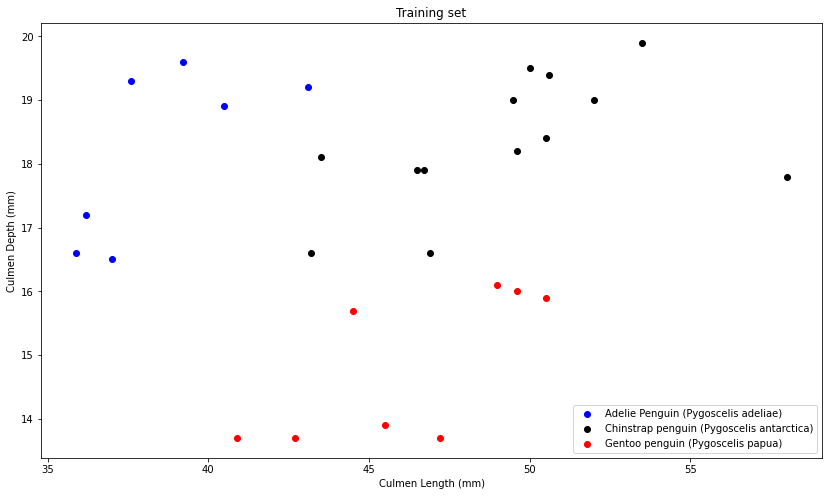

In [6]:
labels = cat_to_idx
label_colours = ['blue', 'black', 'red']

def plot_data(x, y, labels, colours):
    for c in np.unique(y):
        inx = np.where(y == c)
        plt.scatter(x[inx, 0], x[inx, 1], label=labels[c], c=colours[c])
    plt.title("Training set")
    plt.xlabel("Culmen Length (mm)")
    plt.ylabel("Culmen Depth (mm)")
    plt.legend(loc="lower right")
    
plt.figure(figsize=(14, 8))
plot_data(X_train, y_train, labels, label_colours)
plt.show()

## Prior

In [7]:
def get_prior(y):
    priors = np.zeros_like(np.unique(y_train))
    for c_num in range(priors.shape[0]):
        priors[c_num] = np.sum(y_train == c_num)

    priors = priors/priors.sum()
    return tfd.Categorical(probs=priors)

prior = get_prior(y_train)
prior

<tfp.distributions.Categorical 'Categorical' batch_shape=[] event_shape=[] dtype=int32>

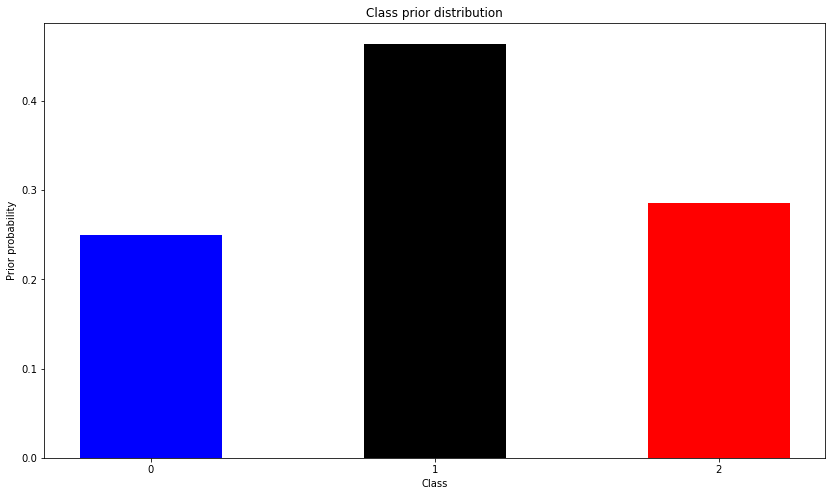

In [8]:
plt.figure(figsize=(14, 8))
plt.bar([0, 1, 2], prior.probs.numpy(), color=label_colours, width=0.5)
plt.xlabel("Class")
plt.ylabel("Prior probability")
plt.title("Class prior distribution")
plt.xticks([0, 1, 2], labels)
plt.show()

## Class conditionals

In [9]:
def get_class_conditionals(x, y):
    locs = np.zeros(shape=(y.max()+1, x.shape[1]))
    scales = np.zeros(shape=(y.max()+1, x.shape[1]))
    
    for c_num in range(y.max()+1):
        mask = (y == c_num)
        locs[c_num] = np.mean(x[mask], axis=0)
        scales[c_num] = np.var(x[mask], axis=0)**0.5

    return tfd.MultivariateNormalDiag(loc=locs, scale_diag=scales)

class_conditionals = get_class_conditionals(X_train, y_train)
class_conditionals

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[3] event_shape=[2] dtype=float64>

## Plot contours

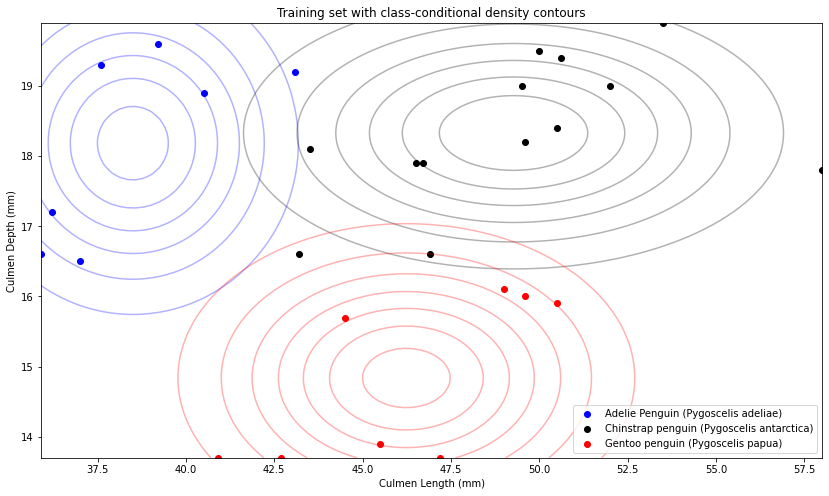

In [10]:
def get_meshgrid(x0_range, x1_range, num_points=100):
    x0 = np.linspace(x0_range[0], x0_range[1], num_points)
    x1 = np.linspace(x1_range[0], x1_range[1], num_points)
    return np.meshgrid(x0, x1)

def contour_plot(x0_range, x1_range, prob_fn, batch_shape, colours, levels=None, num_points=100):
    X0, X1 = get_meshgrid(x0_range, x1_range, num_points=num_points)
    Z = prob_fn(np.expand_dims(np.array([X0.ravel(), X1.ravel()]).T, axis=1))
    Z = np.array(Z).T.reshape(batch_shape, *X0.shape)
    for batch in np.arange(batch_shape):
        if levels:
            plt.contourf(X0, X1, Z[batch], alpha=0.2, colors=colours, levels=levels)
        else:
            plt.contour(X0, X1, Z[batch], colors=colours[batch], alpha=0.3)

plt.figure(figsize=(14, 8))
plot_data(X_train, y_train, labels, label_colours)
x0_min, x0_max = X_train[:, 0].min(), X_train[:, 0].max()
x1_min, x1_max = X_train[:, 1].min(), X_train[:, 1].max()
contour_plot((x0_min, x0_max), (x1_min, x1_max), class_conditionals.prob, 3, label_colours)
plt.title("Training set with class-conditional density contours")
plt.show()

## Predict class

In [13]:
def predict_class(prior, class_conditionals, x):
    cond_prob = class_conditionals.log_prob(np.expand_dims(x, axis=1))
    joint_likelihood = tf.add(np.log(prior.probs), cond_prob)
    norm_factor = tf.reduce_logsumexp(joint_likelihood, axis=-1, keepdims=True)
    log_prob = joint_likelihood - norm_factor

    return tf.argmax(log_prob, axis=-1).numpy()

predictions = predict_class(prior, class_conditionals, X_test)
accuracy = accuracy_score(y_test, predictions)
print("Test accuracy: {:.4f}".format(accuracy))

Test accuracy: 1.0000


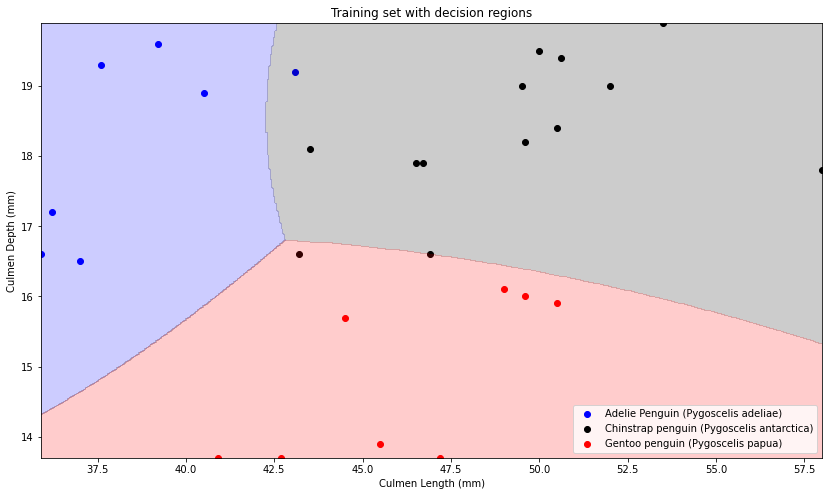

In [14]:
plt.figure(figsize=(14, 8))
plot_data(X_train, y_train, labels, label_colours)
x0_min, x0_max = X_train[:, 0].min(), X_train[:, 0].max()
x1_min, x1_max = X_train[:, 1].min(), X_train[:, 1].max()
contour_plot((x0_min, x0_max), (x1_min, x1_max), 
             lambda x: predict_class(prior, class_conditionals, x), 
             1, label_colours, levels=[-0.5, 0.5, 1.5, 2.5],
             num_points=500)
plt.title("Training set with decision regions")
plt.show()

# Training

## Parameters

In [15]:
scales = tf.Variable([1., 1.], dtype=tf.float32, trainable=True)
optimiser = tf.keras.optimizers.Adam(learning_rate=0.01)
epochs = 300

train_loss_results = []
train_scales_results = []

x = X_train.astype(np.float32)
y = y_train.astype(np.int32)

## Training weights

In [16]:
locs = np.zeros(shape=(y.max()+1, x.shape[1]))
weights = []

for c_num in range(y.max()+1):
    mask = (y == c_num)
    locs[c_num] = np.mean(x[mask], axis=0)
    weights.append(mask.sum())

locs = tf.constant(locs, dtype=tf.float32)
dist = tfd.MultivariateNormalDiag(loc=locs, scale_diag=scales)

# Class Contribution
weights = np.array(weights, dtype=np.float32)
weights = weights/weights.sum()

## Optimize the weights

In [17]:
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        tape.watch(dist.trainable_variables)
        # Negative Log Likelihood
        loss = dist.log_prob(x[:,np.newaxis, :])*tf.one_hot(y, depth=3)
        loss = -tf.reduce_sum(loss)
        # Gradients
        grads = tape.gradient(loss, dist.trainable_variables)
    # Update gradients
    optimiser.apply_gradients(zip(grads, dist.trainable_variables))
    
    train_loss_results.append(loss)
    train_scales_results.append(dist.stddev().numpy()[0])
    
    if epoch%10 == 9:
            print("Epoch: {:03d} \t Loss: {:0.6f} \t StdDev_1: {:0.6f} \t StdDev_2: {:0.6f}".format(1+epoch, 
                                                                                                    loss, 
                                                                                                    train_scales_results[-1][0],
                                                                                                    train_scales_results[-1][1]))

Epoch: 010 	 Loss: 204.694214 	 StdDev_1: 1.098865 	 StdDev_2: 1.089531
Epoch: 020 	 Loss: 186.511993 	 StdDev_1: 1.192160 	 StdDev_2: 1.116784
Epoch: 030 	 Loss: 173.579834 	 StdDev_1: 1.277014 	 StdDev_2: 1.092937
Epoch: 040 	 Loss: 164.247223 	 StdDev_1: 1.352934 	 StdDev_2: 1.080580
Epoch: 050 	 Loss: 157.300476 	 StdDev_1: 1.420808 	 StdDev_2: 1.090783
Epoch: 060 	 Loss: 151.965118 	 StdDev_1: 1.481973 	 StdDev_2: 1.093431
Epoch: 070 	 Loss: 147.739746 	 StdDev_1: 1.537702 	 StdDev_2: 1.088752
Epoch: 080 	 Loss: 144.306351 	 StdDev_1: 1.589029 	 StdDev_2: 1.089601
Epoch: 090 	 Loss: 141.456467 	 StdDev_1: 1.636744 	 StdDev_2: 1.090896
Epoch: 100 	 Loss: 139.050003 	 StdDev_1: 1.681438 	 StdDev_2: 1.089874
Epoch: 110 	 Loss: 136.989517 	 StdDev_1: 1.723554 	 StdDev_2: 1.090042
Epoch: 120 	 Loss: 135.204956 	 StdDev_1: 1.763436 	 StdDev_2: 1.090289
Epoch: 130 	 Loss: 133.644531 	 StdDev_1: 1.801352 	 StdDev_2: 1.090051
Epoch: 140 	 Loss: 132.269043 	 StdDev_1: 1.837516 	 StdDev_2: 1

In [18]:
nlls, scales_arr, class_conditionals = np.array(train_loss_results), np.array(train_scales_results), dist

## Results

In [19]:
print("Class conditional means:")
print(class_conditionals.loc.numpy())
print("\nClass conditional standard deviations:")
print(class_conditionals.stddev().numpy())

Class conditional means:
[[38.5      18.185715]
 [49.269234 18.330769]
 [46.2375   14.837499]]

Class conditional standard deviations:
[[2.2676418 1.0901345]
 [2.2676418 1.0901345]
 [2.2676418 1.0901345]]


In [20]:
stddevs = np.zeros(shape=(2,2))

for c_num in range(2):
    mask = (y_train == c_num)
    stddevs[c_num] = np.mean((X_train[mask]-class_conditionals.loc.numpy()[c_num])**2, axis=0)

print("Expected conditional standard deviations:\n", stddevs)

Expected conditional standard deviations:
 [[ 5.82285714  1.58693878]
 [15.04366864  0.96828402]]


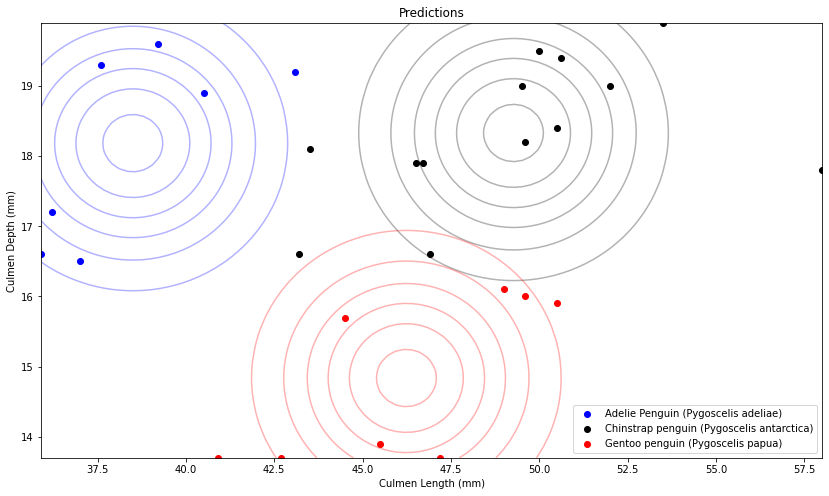

In [21]:
plt.figure(figsize=(14, 8))
plot_data(X_train, y_train, labels, label_colours)
x0_min, x0_max = X_train[:, 0].min(), X_train[:, 0].max()
x1_min, x1_max = X_train[:, 1].min(), X_train[:, 1].max()
contour_plot((x0_min, x0_max), (x1_min, x1_max), class_conditionals.prob, 3, label_colours)
plt.title("Predictions")
plt.show()